# IMPLEMENTATION TASKS

All write-up/report answers for this section of Homework 1 are included as Markdown cells in this Jupyter Notebook. Answers to the math section of HW1 are included in a separate PDF file.

## Q7.1: Inspection 

The Stanford Dogs Dataset (SDD) mostly has high-resolution photos taken in more natural, real-world settings. The dogs are often outside, surrounded by grass, people, or other animals, and the images vary a lot in pose, lighting, and background clutter.

The Dog Breed Images (DBI) dataset, on the other hand, looks a lot more standardized. Many of its images have cleaner or simpler backgrounds, and the dogs are usually centered and well-lit, almost like studio or curated shots. Overall, SDD looks more diverse and realistic but also noisier, while DBI looks cleaner and more consistent.

## Q7.2: Simple CNN Training on the DBI

In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version reported by torch:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Device 0:", torch.cuda.get_device_name(0))

class SimpleCNN(nn.Module):
    # Expects input images of size (3, 224, 224)
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(8 * 56 * 56, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        # NOTE: no softmax here; CrossEntropyLoss does the softmax internally
        x = self.fc2(x)
        return x
    
class SimpleCNN2(nn.Module):
    # Same model as above, but without dropout.
    def __init__(self, num_classes=7):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 56 * 56, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        # NOTE: no softmax here; CrossEntropyLoss does the softmax internally
        x = self.fc2(x)
        return x
    
def train_validate_cnn(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []

    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for i, (inputs, labels) in enumerate(train_iter):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            train_iter.set_postfix(loss=loss.item())

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for inputs, labels in val_iter:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                val_iter.set_postfix(loss=loss.item())

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


In [ ]:
# Test loader is dog-breed-images
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Subset

image_path = "dog-breed-images/"


# TRAIN: random augmentations 
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
    transforms.RandomRotation(degrees=10, fill=0),  # small rotation
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), value='random')
])

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

base_dataset = datasets.ImageFolder(image_path)  # no transform here

# 60/10/30 split (train/val/test)
n = len(base_dataset)
train_size = int(0.6 * n)
val_size   = int(0.1 * n)
test_size  = n - train_size - val_size  # ~30%
gen = torch.Generator().manual_seed(42)
train_subset, val_subset, test_subset = torch.utils.data.random_split(
    base_dataset, [train_size, val_size, test_size], generator=gen
)

# rewrap each split with its own transforms by creating new ImageFolder objects
train_dataset = Subset(datasets.ImageFolder(image_path, transform=train_tfms), train_subset.indices)
val_dataset   = Subset(datasets.ImageFolder(image_path, transform=base_transform),  val_subset.indices)
test_dataset  = Subset(datasets.ImageFolder(image_path, transform=base_transform),  test_subset.indices)

# DataLoaders
cuda = torch.cuda.is_available()
common_loader_kwargs = dict(num_workers=2, pin_memory=cuda, persistent_workers=(2 > 0))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  drop_last=True,  **common_loader_kwargs)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, drop_last=False, **common_loader_kwargs)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, drop_last=False, **common_loader_kwargs)

# If you want to print class names:
classes = datasets.ImageFolder(image_path).classes


# visualize a batch of images
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# show images
imshow(utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


def test_model(model, test_loader, device):
    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    return test_accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:

# Define criterion and optimizer
model = SimpleCNN(num_classes=len(train_loader.dataset.dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
epochs = 10
train_losses, val_losses = train_validate_cnn(model, train_loader, val_loader, criterion, optimizer, epochs, device)

# Test the model
test_model(model, test_loader, device)

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Same as above, but without dropout

# Define criterion and optimizer
model = SimpleCNN2(num_classes=len(train_loader.dataset.dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
epochs = 10
train_losses, val_losses = train_validate_cnn(model, train_loader, val_loader, criterion, optimizer, epochs, device)

# Test the model
test_accuracy = test_model(model, test_loader, device)

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



**Task 2 Report:**

A simple CNN was trained on the Dog Breed Images (DBI) dataset. The model takes RGB inputs of size 3x224x224 and consists of four convolutional layers with batch normalization, ReLU activations, and two max pooling operations that progressively reduce spatial resolution. After flattening, the network includes one hidden fully connected layer with 32 units followed by the output layer, which maps to the number of dog breed classes. The model was trained using the Adam optimizer with a learning rate of 0.001 and weight decay of 1x10^−5, and the loss was computed using cross-entropy.

Two versions of the network were implemented: one with dropout layers (p=0.5) after the convolutional and fully connected layers, and another identical version without dropout. Dropout was introduced to reduce overfitting by randomly deactivating neurons during training, forcing the model to learn more robust feature representations. Both models were trained for 10 epochs with standard data augmentations such as random cropping, horizontal flipping, color jitter, and random erasing to improve generalization.

The training curve for the dropout model shows a gradual and consistent decrease in both training and validation loss over the first several epochs, suggesting the model was learning effectively. However, the overall test accuracy reached only 33.85%, which indicates that while the model reduced its loss, it struggled to generalize well to the held out test data. The validation loss fluctuates slightly across epochs, which is typical when dropout is used, since random neuron deactivation introduces noise during training. Overall, dropout helped stabilize the validation curve and prevent severe overfitting, but given the limited model complexity and size of the dataset, the improvement in generalization was somewhat insignificant, leading to a relatively low final accuracy.

The model without dropout achieved a slightly higher test accuracy of 38.46%, but its training behavior clearly indicates overfitting. The training loss steadily decreases across epochs, while the validation loss remains consistently higher and even fluctuates upward in later epochs. This suggests the model is memorizing details specific to the training data rather than learning generalizable patterns. Without dropout, the network becomes too confident on the training set and struggles to adapt to unseen examples. Although it performs better in raw accuracy, this improvement probably reflects overfitting rather than generalization.



## Task 3: ResNet training
a) In this task, we use the ResNet-18 model for the classification of the images in the DBI dataset. To do so, use the ResNet-18 model from PyTorch, modify the input/output layers to match your dataset, and train the model from scratch; i.e., do not use the pre- trained ResNet. Plot the training and validationaccuracy and report the final test results, and compare those with the results of your CNN model.

b) Run the trained model on the entire SDD dataset and report the accuracy. Compare the accuracy obtained on the (test set of) DBI, vs. the accuracy obtained on the SDD. Which is higher? Why do you think that might be? Explain very briefly, in one or two sentences.

In [ ]:
import torchvision.models as models

# Load an untrained ResNet-18 model
resnet18_untrained = models.resnet18(pretrained=False)

# modify the final layer to match the number of classes in your dataset
num_ftrs = resnet18_untrained.fc.in_features
resnet18_untrained.fc = nn.Linear(num_ftrs, len(train_loader.dataset.dataset.classes))

resnet_model = resnet18_untrained.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 10
train_losses, val_losses = train_validate_cnn(resnet_model, train_loader, val_loader, criterion, optimizer, epochs, device)
test_accuracy = test_model(resnet_model, test_loader, device)

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Run the trained ResNet model on the entirety of the Stanford Dog Dataset (SDD)

sdd_path = "stanford-dogs-dataset/images/"
sdd_dataset = datasets.ImageFolder(sdd_path, transform=base_transform)
sdd_loader = DataLoader(sdd_dataset, batch_size=32, shuffle=False, drop_last=False, **common_loader_kwargs)

test_accuracy = test_model(resnet_model, sdd_loader, device)

**3a and 3b report**:

a) Using the same training hyperparameters from the previous task, the ResNet model scored an accuracy of 31.79% on DBI.

b) When the same model was evaluated on SDD, it achieved an accuracy of 25.39%, noticeably lower than its performance on DBI. This drop is expected, as SDD contains more complex images captured in natural environments, whereas the model was trained exclusively on the more uniform DBI dataset. The difference highlights the impact of domain shift—the model learned features specific to DBI style and background conditions, which do not transfer well to the more diverse SDD imagery.



**3c report:**

Compare the accuracy obtained on the (test set of) DBI, vs. the accuracy obtained on the SDD. Which is higher? Why do you think that might be? Explain very briefly, in one or two sentences.

# Task 4: Fine-Tuning on DBI

Fine tune a number of different pre-trained models on the DBI.

In [ ]:
# load pretrained models
from torchvision import models 

resnet18 = models.resnet18(pretrained=True) # resnet18
resnet34 = models.resnet34(pretrained=True) #resnet34
resnext50 = models.resnext50_32x4d(pretrained=True) #resneXt 50
swintrans = models.swin_t(pretrained=True) #swinTransformer tiny

#fifth model of my choosing: vgg16 
vit = models.vit_b_32(pretrained=True)

# replace final layer for output classes

# modify the final layer to match the number of classes in your dataset

# ResNet18
num_ftrs = resnet18_untrained.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(train_loader.dataset.dataset.classes))

# ResNet34
num_ftrs_34 = resnet34.fc.in_features
resnet34.fc = nn.Linear(num_ftrs_34, len(train_loader.dataset.dataset.classes))

# ResNeXt50
num_ftrs_next = resnext50.fc.in_features
resnext50.fc = nn.Linear(num_ftrs_next, len(train_loader.dataset.dataset.classes))

# Swin Transformer Tiny
num_ftrs_swin = swintrans.head.in_features
swintrans.head = nn.Linear(num_ftrs_swin, len(train_loader.dataset.dataset.classes))

# ViT 32
num_ftrs_vit = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_ftrs_vit, len(train_loader.dataset.dataset.classes))

models_to_train = [
    ("ResNet18", resnet18),
    ("ResNet34", resnet34),
    ("ResNeXt50", resnext50),
    ("SwinTransformerTiny", swintrans),
    ("ViT", vit)
]

results = {}


for name, model in models_to_train:
    print(f"\nTraining {name}...")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    epochs = 10
    train_losses, val_losses = train_validate_cnn(model, train_loader, val_loader, criterion, optimizer, epochs, device)

    dbi_acc = test_model(model, test_loader, device)
    sdd_acc = test_model(model, sdd_loader, device)

    results[name] = {"DBI": dbi_acc, "SDD": sdd_acc}

print("\nSummary of Accuracies:")
for name, accs in results.items():
    print(f"{name}: DBI={accs['DBI']:.2f}%, SDD={accs['SDD']:.2f}%")



**Task 4 Report:**

Summary of Accuracies:

ResNet18: DBI=67.18%, SDD=48.01%

ResNet34: DBI=81.03%, SDD=62.94%

ResNeXt50: DBI=71.28%, SDD=55.47%

SwinTransformerTiny: DBI=15.38%, SDD=17.68%

ViT: DBI=15.90%, SDD=19.63%

Discuss the cross-dataset performance of these trained models. Which models generalized to
the new dataset better? For example, are there cases in which two different models perform
equally well on the test portion of the DBI but have significant performance differences when
evaluated on the SDD? Are there models for which the performance gap between the SSD
and test portion of DBI are very small?

 Among all models, ResNet-34 achieved the highest accuracy on both DBI (81.03%) and SDD (62.94%), showing the strongest ability to learn from and adapt to new data. While ResNet-18 performed reasonably on DBI (67.18%), its SDD accuracy dropped more sharply to 48.01%, which may suggest that the deeper ResNet-34’s additional layers and capacity helped it learn more transferable visual features.

ResNeXt-50 performed worse than ResNet-34 despite being a more complex model, reaching 71.28% on DBI and 55.47% on SDD. This suggests that its group convolutions and higher capacity may have led to slight overfitting to DBI’s distribution, making it less robust when faced with SDD’s more diverse and less controlled image scenes. The Swin Transformer and Vision Transformer (ViT) models performed poorly on both datasets, with accuracies around 15–20%. Their weak results likely stem from their higher data requirements and sensitivity to small datasets, since Transformer architectures typically need much larger training sets to effectively learn.  

When comparing models trained and tested on DBI, ResNet-18 and ResNeXt-50 achieved somewhat similar DBI accuracies, yet their SDD performance diverged substantially. This shows that high within-dataset accuracy does not necessarily lead to good cross-dataset generalization. ResNet-34 achieved not only the top DBI accuracy, but also exhibited the smallest performance gap between DBI and SDD (~18%), indicating that it generalized best overall. In contrast, the transformers had both low absolute accuracy and minimal cross-dataset improvement, suggesting underfitness rather than robust generalization.

Overall, ResNet-34 generalized the best across datasets, while transformer-based models failed to adapt effectively to the data.

# Task 5: Dataset Detection
Train a model that – instead of classifying dog breeds – can distinguish whether a given image is more likely to belong to SDD or DBI. To do so, first, you need to divide your data into training and test data (and possibly validation if you need those for tuning the hyper-parameters of your model). You need to either reorganize the datasets (to load the images using torchvision.datasets.ImageFolder ) or write your own data loader function. You can start from a pre-trained model (of your choice) and fine-tune it on the training portion of the dataset. Include your network model specifications in the report, and make sure to include your justifications for that choice. Report your model’s accuracy on the test portion of the dataset.

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, ConcatDataset, random_split, DataLoader
from torchvision import datasets, transforms, models, utils
import matplotlib.pyplot as plt
import numpy as np

# Define transforms
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), value='random')
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Custom wrapper for relabeling
class RelabeledDataset(Dataset):
    def __init__(self, base_dataset, new_label):
        self.base = base_dataset
        self.new_label = new_label
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        img, _ = self.base[idx]  # ignore original class
        return img, self.new_label

# Load base datasets ONCE
dbi_path = "dog-breed-images/"
sdd_path = "stanford-dogs-dataset/images/"

dbi_base = datasets.ImageFolder(dbi_path, transform=train_tfms)
sdd_base = datasets.ImageFolder(sdd_path, transform=train_tfms)

dbi_dataset = RelabeledDataset(dbi_base, new_label=0)
sdd_dataset = RelabeledDataset(sdd_base, new_label=1)

# Combine & split
combined_dataset = ConcatDataset([dbi_dataset, sdd_dataset])
n = len(combined_dataset)
train_size = int(0.7 * n)
val_size   = int(0.1 * n)
test_size  = n - train_size - val_size

gen = torch.Generator().manual_seed(42)
train_set, val_set, test_set = random_split(combined_dataset, [train_size, val_size, test_size], generator=gen)

print(f"Train samples: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")



# dataloaders (Jupyter-safe)
cuda = torch.cuda.is_available()
common_loader_kwargs = dict(num_workers=0, pin_memory=cuda, persistent_workers=False)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, **common_loader_kwargs)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, drop_last=False, **common_loader_kwargs)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, drop_last=False, **common_loader_kwargs)

print("DataLoaders ready.")

# Visualize a batch

def imshow(img_tensor):
    npimg = img_tensor.numpy()
    plt.figure(figsize=(10,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(utils.make_grid(images[:8], nrow=4, normalize=False))
print("Labels (0=DBI, 1=SDD):", labels[:8].tolist())

# Initialize ResNet-34
resnet34 = models.resnet34(pretrained=True)
num_ftrs = resnet34.fc.in_features
resnet34.fc = nn.Linear(num_ftrs, 2)  # Binary output
model = resnet34
print(" Model ready for training (ResNet-34 fine-tuning)")


In [ ]:
# Train model
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
epochs = 10
train_losses, val_losses = train_validate_cnn(model, train_loader, val_loader, criterion, optimizer, epochs, device)

dbi_sdd_acc = test_model(model, test_loader, device)

**Report on Task 5:**

I selected ResNet-34 as the architecture. ResNet-34 is a convolutional neural network composed of 34 layers with residual skip connections that mitigate vanishing gradients and allow for effective training of deeper networks. This model performed quite well in the previous task of identifying dog breeds when trained on the DBI set and tested on SDD, which led me to believe it is capable of learning effective distinguishable features related to dog breeds.  

The model was initialized with ImageNet pre-trained weights to leverage general visual features such as edges, textures, and object parts, which accelerates convergence and improves performance on limited data. The final fully connected layer (fc) was replaced with a new nn.Linear(in_features, 2) layer to produce logits for the two dataset classes:

Class 0: Dog Breed Images DBI
Class 1:  Stanford Dogs Dataset SDD

The network was fine-tuned end-to-end using the Adam optimizer (lr = 0.001, weight_decay = 1e-5) and a cross-entropy loss function over 10 epochs. Data augmentations (random crops, flips, color jitter, and random erasing) were applied to increase robustness to variations in lighting, pose, and cropping between datasets. Validation loss was monitored after each epoch to detect potential overfitting.

The selected model achieved a Test Accuracy of 82.76% on distinguishing images between SDD and DBI on unseen data. This indicates that the network successfully learned distribution-level differences between the two datasets—such as variations in background composition, lighting, or image resolution—rather than specific breed features. The relatively high accuracy demonstrates that ResNet-34 effectively transfered learned representations from the ImageNet database it was originally trained on, and can discern subtle dataset characteristics.




## Task 6: How to improve performance on SDD?
If our goal were to have good performance on the SDD dataset, briefly discuss how to work towards this goal in each of the following cases: (you don’t need to implement these, just briefly discuss each case in 2-3 sentences)

Case 1: Access to DBI only (no SDD data):

If only DBI is available, the best approach is to use domain generalization techniques. This could include stronger data augmentation to attempt to recreate the natural variation of SDD (diverse lighting, cluttered backgrounds, outdoor textures, etc.), as well as regularization methods like dropout. Using a larger pretrained model (e.g., ResNet-50 or ConvNeXt) and early stopping can also help the model learn more transferable, general visual features that adapt better to unseen domains.

Case 2: Access to DBI and a small labeled subset of SDD:

A good strategy in this case would be fine-tuning. First, train the model on DBI to learn general dog features, then fine-tune the network on the labeled SDD subset at a lower learning rate. This allows the model to adapt to SDD specific characteristics while retaining general breed recognition knowledge from DBI. 

Case 3: Access to DBI and an unlabeled subset of SDD:

If SDD images are available without labels, the only realistic option to utilize this data would be unsupervised domain adaptation techniques. For example, we could apply self-supervised pretraining (e.g., contrastive learning) on the unlabeled SDD images to align the feature distributions of DBI and SDD. Contrastive learning teaches the model to recognize which images are visually similar or different, based purely on their content rather than their labels. For example, by comparing multiple augmented versions of the same dog image, the model learns to identify consistent features like fur texture, face shape, or pose, while ignoring differences caused by lighting or background. This helps the network develop a representation that focuses on the actual dogs rather than the environmental context, making it more robust to the natural, cluttered scenes in SDD, even without labeled supervision.

# Task 7: Discussion

Briefly discuss how some of the issues that were examined in this exercise can have implications in real application, e.g. as related to bias or performance. For example, consider the case where available training datasets are collected in one setting (e.g. a university) and the goal is to deploy trained models in another setting (e.g. a retirement home).

This exercise shows how dataset bias and domain differences can significantly impact model performance in real-world applications. A model trained on one dataset, such as the DBI collection with clean, centered subjects, may perform well in that controlled setting but struggle when applied to a different domain, like the SDD, which features more natural and less controlled diverse scenes. In real applications, this kind of mismatch can occur when data is collected in one environment but deployed in another. For instance, a vision model trained on well-lit hospital images might fail in a dimly lit retirement home or images captured from a camera with significantly different color balance. These results show that models often learn not just the intended task but also subtle cues from their training environment, leading to biased or unreliable predictions elsewhere. Avoiding this requires techniques like domain adaptation, data augmentation, and more diverse data collection to ensure models generalize well.


# Question 8: Tracking Comparison
Use a face detection model (such as MediaPipe Face Detection, OpenCV’s DNN face detector, or MTCNN) to detect the face in the first frame of the video.

Initialize three different face trackers with the detected bounding box:

• CSRT Tracker or KCF Tracker (both have OpenCV implementation)

• Two other trackers: research and select two additional trackers of your choosing. 

## Performance Analysis:
• Track the face through all frames of the video using each of the three trackers.

• For ground truth comparison, run your face detection model on every 5th frame to establish reference bounding boxes. For this assignment, we’re going to assume that the face detection model is perfect and gives us the ground truth location of the face.

• Calculate the intersection over union (IoU) between each tracker’s predicted bounding box and the ground truth for these reference frames.

• (5 marks) Create a comparison plot showing IoU over time for all three trackers on the same graph, with different colors/line styles for each tracker.

In [5]:
import cv2 
import numpy as np

# initialize cv2 neural network face detector
net = cv2.dnn.readNetFromCaffe("models/deploy.prototxt.txt", "models/res10_300x300_ssd_iter_140000.caffemodel")

# create function to detect faces in an image
def detect_faces(image):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
        (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    faces = []
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            faces.append((startX, startY, endX, endY))
    return faces

def to_xywh(box_xyxy):
    x1, y1, x2, y2 = box_xyxy
    return (int(x1), int(y1), int(x2 - x1), int(y2 - y1))

# break video into array of frames 
def video_to_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

frames = video_to_frames("TheOffice.mp4") # let's try to use a different video (of my own face) to reduce track seduction

# get first frame and detect face
first_face_bbox = to_xywh(detect_faces(frames[0])[0])
gt = [] # ground truth boxes 
gt.append([0, first_face_bbox]) # frame number, (x, y, w, h)    

tracker = cv2.TrackerCSRT_create() # Initialize the CSRT tracker
tracker.init(frames[0], first_face_bbox) # tracker wants (x, y, w, h)

goturn_tracker = cv2.TrackerGOTURN.create() # initialize the GOTURN tracker
goturn_tracker.init(frames[0], first_face_bbox)

mosse_tracker = cv2.legacy.TrackerMOSSE_create()
mosse_tracker.init(frames[0], first_face_bbox)

tracks = {"CRST": [],
          "GOTURN": [],
          "MOSSE": []}

# loop through all frames and track the face
for i, frame in enumerate(frames):
    # Update the CRST tracker and get the new bounding box
    success, bbox = tracker.update(frame)
    goturn_success, goturn_bbox = goturn_tracker.update(frame)
    mosse_success, mosse_bbox = mosse_tracker.update(frame)

    if success:
        # Draw the bounding box on the frame
        x, y, w, h = [int(v) for v in bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, "CRST Tracking", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
        tracks["CRST"].append([i, (x, y, w, h)]) # store frame number and bbox
    else:
        # Tracking failed
        cv2.putText(frame, "CRST Tracking failed!", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

    
    if goturn_success:
        x, y, w, h = [int(v) for v in goturn_bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, "GOTURN Tracking", (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2)
        tracks["GOTURN"].append([i, (x, y, w, h)]) # store frame number and bbox
    else:
        cv2.putText(frame, "GOTURN Tracking failed!", (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)


    if mosse_success:
        x, y, w, h = [int(v) for v in mosse_bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
        cv2.putText(frame, "MOSSE Tracking", (100, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 255), 2)
        tracks["MOSSE"].append([i, (x, y, w, h)]) # store frame number and bbox

    # detect face for every fifth frame as ground truth
    if i % 5 == 0 and i != 0:
        faces = detect_faces(frame)
        if len(faces) > 0:
            x, y, w, h = to_xywh(faces[0])
            gt.append([i, to_xywh(faces[0])]) # store frame number and bbox
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2) # red box for ground truth
            cv2.putText(frame, "Ground Truth", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            

    # Display the frame
    cv2.imshow("Tracking", frame)
    # Exit on 'q' press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    # press q to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

print("Ground Truth:", gt)
print("Tracks:", tracks)

tracks['ground_truth'] = gt

# save tracks dict as json
import json
with open("tracks.json", "w") as f:
    json.dump(tracks, f)


Ground Truth: [[0, (392, 60, 77, 117)], [5, (391, 58, 82, 120)], [10, (392, 57, 82, 117)], [15, (390, 57, 87, 118)], [20, (391, 61, 81, 117)], [25, (392, 68, 88, 122)], [30, (391, 75, 85, 114)], [35, (390, 65, 82, 117)], [40, (386, 67, 79, 115)], [50, (413, 70, 82, 115)], [55, (445, 72, 70, 124)], [60, (445, 94, 78, 108)], [65, (429, 94, 80, 120)], [70, (393, 93, 76, 106)], [75, (357, 71, 81, 116)], [80, (367, 86, 76, 118)], [85, (410, 79, 71, 116)], [205, (2, 114, 104, 101)], [270, (456, 215, 36, 44)], [275, (449, 216, 43, 47)], [280, (447, 203, 46, 46)], [285, (456, 206, 45, 49)]]
Tracks: {'CRST': [[0, (392, 60, 77, 117)], [1, (392, 60, 77, 117)], [2, (392, 60, 77, 117)], [3, (392, 59, 77, 117)], [4, (393, 61, 75, 115)], [5, (392, 59, 77, 117)], [6, (392, 59, 77, 117)], [7, (392, 59, 77, 117)], [8, (393, 60, 75, 115)], [9, (392, 58, 77, 117)], [10, (393, 60, 75, 115)], [11, (392, 58, 77, 117)], [12, (392, 58, 77, 117)], [13, (392, 58, 77, 117)], [14, (392, 58, 77, 117)], [15, (392, 5

Average IoU for CRST: 0.6877
Average IoU for GOTURN: 0.4648
Average IoU for MOSSE: 0.6894


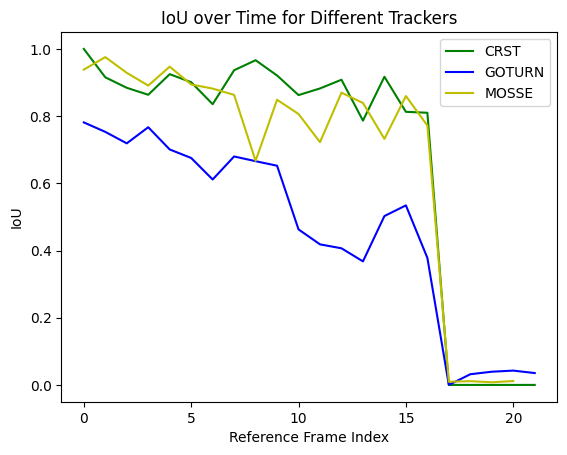

In [6]:
# Calculate the intersection over union (IoU) between each tracker’s predicted bounding box and the ground truth for these reference frames.
ious = {"CRST": [], "GOTURN": [], "MOSSE": []}
def bb_intersection_over_union(boxA, boxB):
    # boxes are stored as (x,y,w,h)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

for method in ["CRST", "GOTURN", "MOSSE"]:
    for gt_frame, gt_box in gt:
        # find the corresponding box in tracks
        pred_boxes = [box for frame, box in tracks[method] if frame == gt_frame]
        if len(pred_boxes) > 0:
            pred_box = pred_boxes[0]
            iou = bb_intersection_over_union(gt_box, pred_box)
            ious[method].append(iou)
    if len(ious[method]) > 0:
        avg_iou = sum(ious[method]) / len(ious[method])
    else:
        avg_iou = 0
    print(f"Average IoU for {method}: {avg_iou:.4f}")

# Create a comparison plot showing IoU over time for all three trackers on the same graph, with different colors/line styles for each tracker.
import matplotlib.pyplot as plt
for method, color in zip(["CRST", "GOTURN", "MOSSE"], ['g', 'b', 'y']):
    plt.plot(range(len(ious[method])), ious[method], label=method, color=color)

plt.xlabel("Reference Frame Index")
plt.ylabel("IoU")
plt.title("IoU over Time for Different Trackers")
plt.legend()
plt.savefig("iou_comparison.png")# save plot as png


plt.show()



# Summary Table:

In [ ]:
import time
import pandas as pd

# compute Average IoU and Count of IoU 
summary_data = []
for method in ["CRST", "GOTURN", "MOSSE"]:
    avg_iou = np.mean(ious[method]) if len(ious[method]) > 0 else 0
    high_iou_count = np.sum(np.array(ious[method]) > 0.8)
    summary_data.append({
        "Tracker": method,
        "Average IoU": round(avg_iou, 3),
        "Frames with IoU > 0.8": int(high_iou_count)
    })

# estimate FPS 
# time a single run of each tracker on a subset of frames
fps_results = {}

for method in ["CRST", "GOTURN", "MOSSE"]:
    # Reinitialize trackers for fair comparison
    if method == "CRST":
        tracker_tmp = cv2.TrackerCSRT_create()
    elif method == "GOTURN":
        tracker_tmp = cv2.TrackerGOTURN_create()
    else:  # MOSSE
        tracker_tmp = cv2.legacy.TrackerMOSSE_create()

    # Start timer
    tracker_tmp.init(frames[0], to_xywh(detect_faces(frames[0])[0]))
    start_time = time.time()
    frame_count = 0

    for frame in frames[:100]:  # test on first 100 frames to estimate
        success, _ = tracker_tmp.update(frame)
        frame_count += 1
    elapsed_time = time.time() - start_time
    fps = frame_count / elapsed_time
    fps_results[method] = round(fps, 2)

# Merge FPS results into summary_data
for entry in summary_data:
    entry["FPS"] = fps_results[entry["Tracker"]]

# Create and display DataFrame (neater way to visualize the table in the library)
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df[["Tracker", "Average IoU", "Frames with IoU > 0.8", "FPS"]]

print("Tracker Performance Summary Table")
display(summary_df)


=== Tracker Performance Summary ===


,Tracker,Average IoU,Frames with IoU > 0.8,FPS
0,CRST,0.688,16,32.78
1,GOTURN,0.465,0,27.37
2,MOSSE,0.689,13,1334.51



```
Tracker	Average |   IoU |   Frames with IoU > 0.8   |	FPS
CRST            | 0.688 |   16                    	|   32.78
GOTURN	        | 0.465 |   0	                    |   7.37
MOSSE	        | 0.689 |	13  	                |   1334.51
```


For my second and third trackers, I selected GOTURN and MOSSE. I chose them as they were already implemented in OpenCV, but also because I thought it would be interesting to represent two contrasting approaches to visual tracking. GOTURN is a deep learning–based tracker that uses a CNN to predict object motion between frames, while MOSSE is a classical correlation filter based tracker. I thought it would be interesting to compare how a neural approach and a lightweight classical one perform on the same video, and these were both said to have good performance according to online articles (such as: https://broutonlab.com/blog/opencv-object-tracking/).